# Application: predicting VIX

The **CBOE Volatility Index (VIX)** measures the annualized option-implied volatility on the S&P 500 stock market index over the next 30 days. It is natural to expect that media sentiment and political uncertainty partly explain the expected volatility measured by the VIX. In this notebook, we test this using sentiment variables constructed from the `usnews` dataset.

## Download VIX data

In [1]:
library("repmis")

vixObject <- "https://github.com/sborms/sentometrics/blob/master/examples/vix.rda?raw=true"
source_data(vixObject)


SHA-1 hash of the downloaded data file is:
741482d702fe2d4694dbe6b105f907ee37f87fa9


[1] "vix"

# Step 0: Create a corpus

In [2]:
library("sentometrics")
library("quanteda")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Package version: 3.2.0
Unicode version: 13.0
ICU version: 69.1
Parallel computing: 24 of 24 threads used.
See https://quanteda.io for tutorials and examples.


In [3]:
uscorpus <- sento_corpus(sentometrics::usnews)

# Step 1: Add features to each document

In the previous notebook, we saw how we can add features to a corpus from a list of words or a regex. Instead of trying to manually list the words (or regular expressions) that are relevant to certain topic, we can also take a more generic approach. With a **Structural Topic Model** (STM), we can automatically find a limited set of words that are related to an underlying topic.

In [4]:
library("stm")

stm v1.3.6 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com


## Compute a document-feature matrix

Before we can estimate an STM, we need a **document-feature matrix** (DFM). The value at row $i$ and column $j$ of our **document-feature matrix** will tell us how often token $j$ (i.e. a word) occurs in document $i$ (i.e. a news paper article).

We make a couple of modifications to obtain a more useful DFM:

- Don't include punctuations and numbers
- Remove typical English stop words that bear little information
- Only keep words that are in the 95% percentile of how frequently they occur
- Remove words that take up more than 10% of all word counts per document
- Remove empty documents

In [5]:
dfm <- tokens(uscorpus, what = "word", remove_punct = TRUE, remove_numbers = TRUE) %>%  # Don't include punctuations and numbers
  dfm(tolower = TRUE) %>%
  dfm_remove(stopwords("en"), min_nchar = 3) %>%  # Remove typical English stop words that bear little information
  dfm_trim(min_termfreq = 0.95, termfreq_type = "quantile") %>%  # Only keep words that are in the 95% percentile of how frequently they occur
  dfm_trim(max_docfreq = 0.10, docfreq_type = "prop") %>%  # Remove words that take up more than 10% of all word counts per document
  dfm_subset(ntoken(.) > 0)  # Remove empty documents

## Estimate the Structural Topic Model

With this DFM, we can estimate our STM. We want to extract **8 topics**. Note that estimating the STM might take a while...

In [6]:
topicModel <- stm(dfm, K = 8, verbose = FALSE)

## Create a terms matrix

Now, for each topic, we take the **5 words with the highest probability**.

In [7]:
topTerms <- labelTopics(topicModel, n = 5)[['prob']]  # Take the 5 words with the highest prob

In [8]:
dim(topTerms)

[1] 8 5

In [9]:
topTerms

funds,fund,bonds,capital,investments
banks,credit,debt,loans,mortgage
reported,labor,decline,second,economist
tax,budget,house,congress,bush
share,corp,industry,executive,cents
bond,oil,composite,yield,close
workers,state,work,states,health
trade,currency,central,china,european


## Use the terms matrix to add features to the corpus

We convert `topTerms` into a named list `keywords` to pass to `add_features()`:

In [10]:
keywords <- lapply(1:nrow(topTerms), function(i) topTerms[i, ])
names(keywords) <- paste0("TOPIC_", 1:length(keywords))

In [11]:
keywords

$TOPIC_1
[1] "funds"       "fund"        "bonds"       "capital"     "investments"

$TOPIC_2
[1] "banks"    "credit"   "debt"     "loans"    "mortgage"

$TOPIC_3
[1] "reported"  "labor"     "decline"   "second"    "economist"

$TOPIC_4
[1] "tax"      "budget"   "house"    "congress" "bush"    

$TOPIC_5
[1] "share"     "corp"      "industry"  "executive" "cents"    

$TOPIC_6
[1] "bond"      "oil"       "composite" "yield"     "close"    

$TOPIC_7
[1] "workers" "state"   "work"    "states"  "health" 

$TOPIC_8
[1] "trade"    "currency" "central"  "china"    "european"

A feature value per news article, normalized between 0 and 1, is generated for each topic, depending on how often the 5 relevant words appear in the news.

In [12]:
uscorpus <- add_features(uscorpus,
                         keywords = keywords,
                         do.binary = FALSE,  # Set to FALSE to get the normalized number of times the keywords occur in the text
                         do.regex = FALSE)

In [13]:
docvars(uscorpus)

date,wsj,wapo,economy,noneconomy,TOPIC_1,TOPIC_2,TOPIC_3,TOPIC_4,TOPIC_5,TOPIC_6,TOPIC_7,TOPIC_8
1995-01-02,0,1,1,0,0.10,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0
1995-01-05,1,0,0,1,0.00,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.1
1995-01-05,0,1,0,1,0.10,0.00000000,0.0000000,0.00000000,0.00000000,0.33333333,0.00000000,0.1
1995-01-08,0,1,0,1,0.00,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.00000000,0.0
1995-01-09,1,0,0,1,0.00,0.05263158,0.0000000,0.00000000,0.06666667,0.00000000,0.00000000,0.0
1995-01-09,0,1,1,0,0.05,0.00000000,0.1111111,0.00000000,0.06666667,0.00000000,0.30434783,0.0
1995-01-10,1,0,1,0,0.00,0.05263158,0.0000000,0.00000000,0.06666667,0.08333333,0.00000000,0.0
1995-01-10,0,1,0,1,0.00,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0.08695652,0.0
1995-01-11,1,0,0,1,0.00,0.10526316,0.1111111,0.00000000,0.00000000,0.00000000,0.00000000,0.2
1995-01-16,1,0,0,1,0.05,0.00000000,0.1111111,0.00000000,0.00000000,0.00000000,0.04347826,0.3


# Step 2 + 3: Sentiment computation and index aggregation combined

`sentometrics` allows us to combine the sentiment computation and index aggregation into a single step. For this, we define the lexicon and the aggregation settings and pass these to the `sento_measures()` method.

## Create the lexicons

For this application, we will use multiple lexicons. We will again use the `list_valence_shifters` from `sentometrics`.

In [14]:
library("lexicon")

In [15]:
lexiconsIn <- c(
  list_lexicons[c("LM_en", "HENRY_en", "GI_en")],
  list(
    NRC = hash_sentiment_nrc,
    HULIU = hash_sentiment_huliu,
    SENTIWORD = hash_sentiment_sentiword,
    JOCKERS = hash_sentiment_jockers,
    SENTICNET = hash_sentiment_senticnet,
    SOCAL = hash_sentiment_socal_google
  )
)

lex <- sento_lexicons(lexiconsIn = lexiconsIn,
                      valenceIn = list_valence_shifters[["en"]][, c("x", "t")])

## Define the sentiment index aggregation specifications

* `howWithin`: This argument defines how sentiment is aggregated within the same document (or sentence). It is passed on to the how argument of the `compute_sentiment()` function. Two common normalization schemes are dividing the sentiment score by the total number of words (`"proportional"`) or by the number of polarized words (`"proportionalPol"`) in the document (or sentence).
* `howDocs`: This argument defines how sentiment is aggregated across all documents at the same date (or frequency). The option `"equal_weight"` gives the same weight to every document.
* `howTime`: * `howTime`: This argument defines how sentiment is aggregated across dates, to smoothen the time series and to acknowledge that sentiment at a given point is at least partly based on sentiment and information from the past. `"beta"` gives weights based on the Beta weighting curve from Ghysels, Sinko, and Valkanov (2007), with parameters set by `aBeta` and `bBeta`.
* `lag`: how far to go back in time for aggregating across dates.
* `fill`: How to add in dates for which not a single document was available. When set to `"latest"`, these missing dates are given a value of the most recent value.

In [16]:
ctrAggPred <- ctr_agg(
    howWithin = "proportionalPol",
    howDocs = "equal_weight",
    howTime = "beta",
    by = "day",
    fill = "latest",
    lag = 270,
    aBeta = 1:3,
    bBeta = 1:2
)

## Compute the sentiment and aggregate into textual sentiment time series

In [17]:
sentMeasPred <- sento_measures(uscorpus, lexicons = lex, ctr = ctrAggPred)

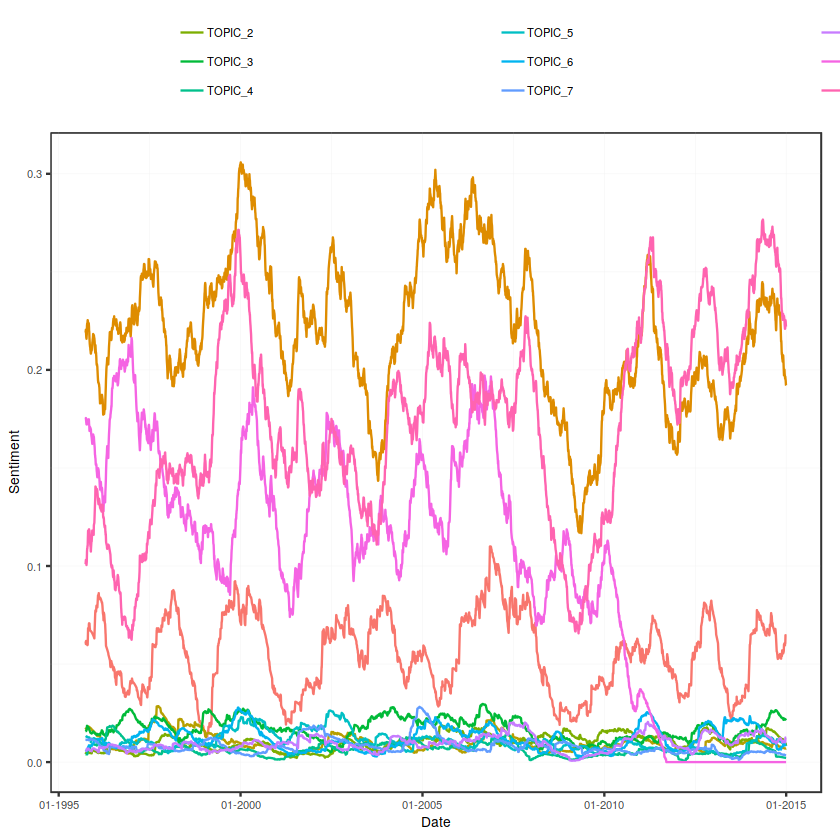

In [18]:
plot(sentMeasPred, group = "features")

# Step 4: modeling

Finally, we fit a linear regression model on the sentiment time series to predict the VIX index.

## Align the sentiment measures and the VIX data

To make sure the sentiment measures and the VIX data are aligned date-wise, we perform some rearrangements.

In [19]:
sentMeasIn <- subset(sentMeasPred, date %in% vix$date)
datesIn <- get_dates(sentMeasIn)
y <- vix[vix$date %in% datesIn, value]
x <- data.frame(lag = y)

## Prepare the regression model specifications

The regression model we will run is the high-dimensional elastic net regression, given that we have many explanatory sentiment variables. For details about the high-dimensional regression framework, see the glmnet package. We want to do a true out-of-sample analysis rolling forward through time, hence we set `do.iter = TRUE` and define a sample size of 60. We are trying to predict the VIX variable 6 months ahead (`h = 6`).

In [20]:
ctrIter <- ctr_model(model = "gaussian",
                     type = "BIC",
                     h = 6,
                     alphas = c(0, 0.1, 0.3, 0.5, 0.7, 0.9, 1),
                     do.iter = TRUE,
                     oos = 5, # h - 1
                     nSample = 60,
                     nCore = 1,
                     do.progress = FALSE)

## Fit and assess the elastic net model iteratively over time

The `sento_model()` function runs the model estimations iteratively and keeps track of the out-of-sample performance. Through the `x` argument, we slide the VIX index as autoregressive component into the regression equation. Omit this argument if you only want to use the sentiment variables as explanatory variables.

In [21]:
out <- sento_model(sentMeasIn, x = x, y = y, ctr = ctrIter)

summary(out)

Model specification 
- - - - - - - - - - - - - - - - - - - - 
 
Model type: gaussian 
Calibration: via BIC information criterion 
Sample size: 60 
Total number of iterations/predictions: 161 
Optimal average elastic net alpha parameter: 0.77 
Optimal average elastic net lambda parameter: 7.59 
 
Out-of-sample performance 
- - - - - - - - - - - - - - - - - - - - 
 
Mean directional accuracy: 43.75 % 
Root mean squared prediction error: 11.34 
Mean absolute deviation: 8.81


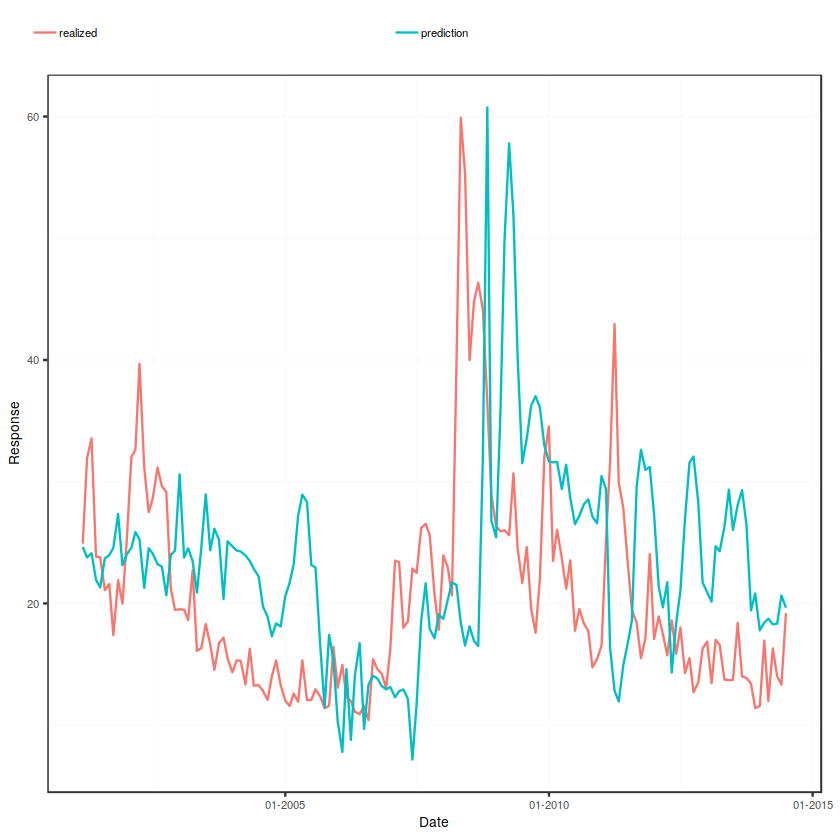

In [22]:
plot(out)